In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

import seaborn as sns
from pylab import rcParams

/Users/swapnilpote/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 8
sns.set_style('whitegrid')
plt.rc("font", size = 18)

In [3]:
data = pd.read_csv('bank.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
print(data.shape)
print(data.columns)

(41188, 21)
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')


### Input variables

- age (numeric)
- job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-- employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
- marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)
- education (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
- default: has credit in default? (categorical: “no”, “yes”, “unknown”)
- housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
- loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
- contact: contact communication type (categorical: “cellular”, “telephone”)
- month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
- day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)
- emp.var.rate: employment variation rate — (numeric)
- cons.price.idx: consumer price index — (numeric)
- cons.conf.idx: consumer confidence index — (numeric)
- euribor3m: euribor 3 month rate — (numeric)
- nr.employed: number of employees — (numeric)


### Predict variable (desired target):

- y: has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)

In [5]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'], dtype=object)

In [6]:
data.loc[data['education'] == 'basic.4y', 'education'] = 'basic'

data.loc[data['education'] == 'basic.6y', 'education'] = 'basic'

data.loc[data['education'] == 'basic.9y', 'education'] = 'basic'

In [7]:
data['education'].unique()

array(['basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

## Data Exploration

In [8]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

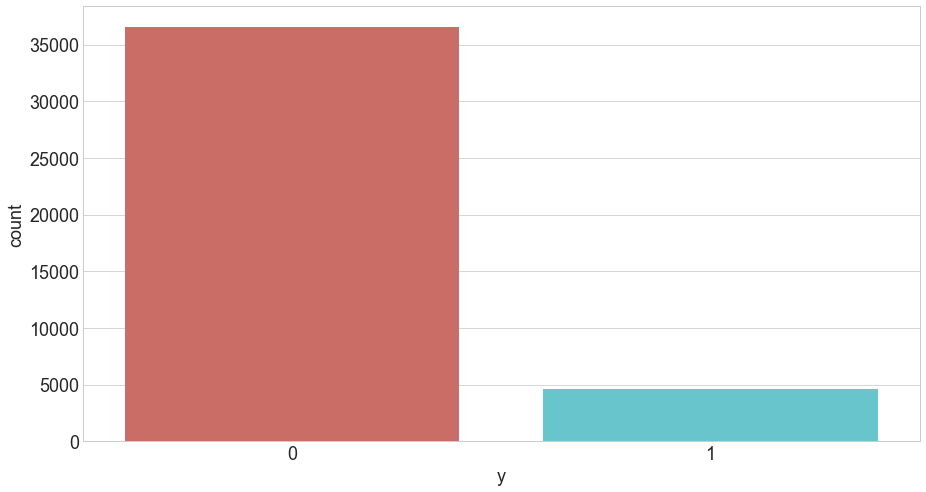

In [9]:
sns.countplot(x = 'y', data = data, palette = 'hls')
plt.show()
plt.savefig('count_plot')

There are 36548 no’s and 4640 yes’s in the outcome variables.

Let’s get a sense of the numbers across the two classes.

In [10]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


#### Observations:

- The average age of customers who bought the term deposit is higher than that of the customers who didn’t.
- The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
- Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [11]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [12]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [13]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


## Visualizations

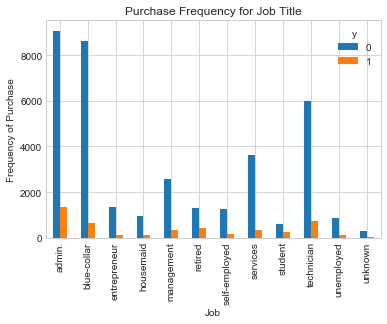

In [14]:
%matplotlib inline

pd.crosstab(data.job, data.y).plot(kind='bar')

plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

plt.savefig('purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

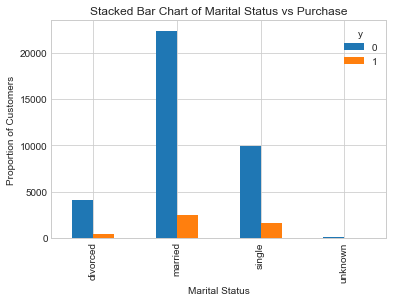

In [15]:
pd.crosstab(data.marital, data.y).plot(kind='bar')

plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

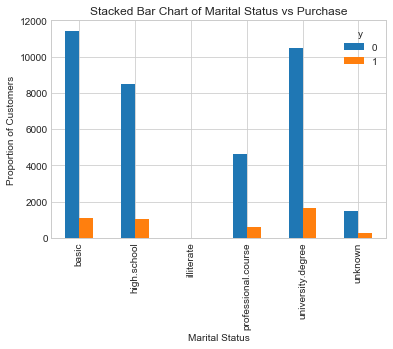

In [16]:
pd.crosstab(data.education, data.y).plot(kind='bar')

plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

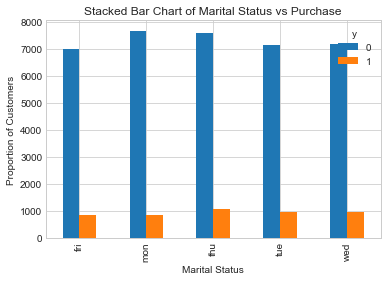

In [17]:
pd.crosstab(data.day_of_week, data.y).plot(kind='bar')

plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

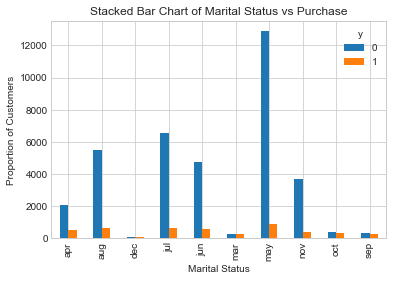

In [18]:
pd.crosstab(data.month, data.y).plot(kind='bar')

plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

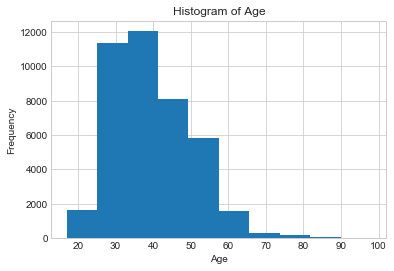

In [19]:
data.age.hist()

plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

Most of the customers of the bank in this dataset are in the age range of 30–40.

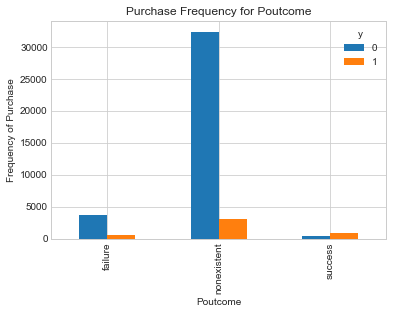

In [20]:
pd.crosstab(data.poutcome, data.y).plot(kind='bar')

plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

## Create dummy variable

In [21]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [22]:
job = pd.get_dummies(data.job, prefix = 'job', prefix_sep='_', drop_first = True)
job.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0


In [23]:
marital = pd.get_dummies(data.marital, prefix = 'marital', prefix_sep='_', drop_first = True)
marital.head()

,marital_married,marital_single,marital_unknown
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [24]:
education = pd.get_dummies(data.education, prefix = 'education', prefix_sep='_', drop_first = True)
education.head()

,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,1,0
3,1,0,0,0,0
4,0,0,0,0,0


In [25]:
default = pd.get_dummies(data.default, prefix = 'default', prefix_sep='_', drop_first = True)
default.head()

,default_unknown,default_yes
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0


In [26]:
housing = pd.get_dummies(data.housing, prefix = 'housing', prefix_sep='_', drop_first = True)
housing.head()

,housing_unknown,housing_yes
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1


In [27]:
loan = pd.get_dummies(data.loan, prefix = 'loan', prefix_sep='_', drop_first = True)
loan.head()

,loan_unknown,loan_yes
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [28]:
contact = pd.get_dummies(data.contact, prefix = 'contact', prefix_sep='_', drop_first = True)
contact.head()

,contact_telephone
0,0
1,0
2,0
3,0
4,0


In [29]:
month = pd.get_dummies(data.month, prefix = 'month', prefix_sep='_', drop_first = True)
month.head()

,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0


In [30]:
day_of_week = pd.get_dummies(data.day_of_week, prefix = 'day_of_week', prefix_sep='_', drop_first = True)
day_of_week.head()

,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,0,1,0,0
1,0,0,0,0
2,0,1,0,0
3,0,0,0,0
4,0,0,0,0


In [31]:
poutcome = pd.get_dummies(data.poutcome, prefix = 'poutcome', prefix_sep='_', drop_first = True)
poutcome.head()

,poutcome_nonexistent,poutcome_success
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1


In [32]:
data.drop(['poutcome', 'day_of_week', 'month', 'contact', 'loan', 'housing', 'default', 'education', 'marital', 'job'],axis=1,inplace=True)
data.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,1


In [33]:
data_final = pd.concat([poutcome, day_of_week, month, contact, loan, housing, default, education, marital, job, data],axis=1)
data_final.head()

,poutcome_nonexistent,poutcome_success,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,month_aug,month_dec,month_jul,month_jun,...,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,1,0,0,1,0,0,1,0,0,0,...,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0
1,1,0,0,0,0,0,0,0,0,0,...,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0
2,0,1,0,1,0,0,0,0,0,1,...,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,1
3,1,0,0,0,0,0,0,0,0,0,...,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0
4,0,1,0,0,0,0,1,0,0,0,...,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,1


In [34]:
data_final.columns

Index(['poutcome_nonexistent', 'poutcome_success', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'contact_telephone',
       'loan_unknown', 'loan_yes', 'housing_unknown', 'housing_yes',
       'default_unknown', 'default_yes', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'marital_married',
       'marital_single', 'marital_unknown', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'age', 'duration', 'campaign', 'pdays',
       'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
       'euribor3m', 'nr_employed', 'y'],
      dtype='object')

## Checking for independence between features

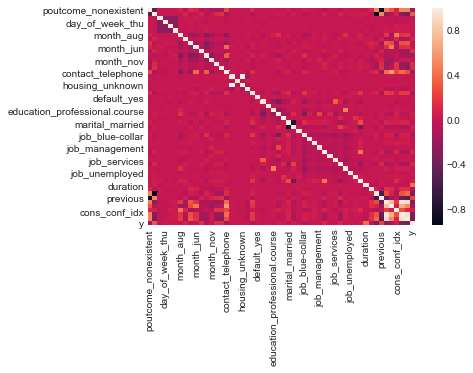

In [35]:
sns.heatmap(data_final.corr())

In [36]:
X = data_final.iloc[:, :-1].values
y = data_final.iloc[:, 0].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)

## Deploying and evaluating the model

In [38]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
y_pred = LogReg.predict(X_test)

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[1100,    0],
       [   0, 7138]])

The results from the confusion matrix are telling us that 1100 and 7138 are the number of correct predictions. 0 and 0 are the number of incorrect predictions.

## Training and Testing accuracy

In [41]:
print('Training score {}'.format(LogReg.score(X_train, y_train)))
print('Testing score {}'.format(LogReg.score(X_test, y_test)))

Training score 1.0
Testing score 1.0
